Problématique
Le client gère des distributeurs de boissons sur des quais de gare. Un employé passe une fois par semaine recharger les machines. Cet employé indique régulièrement que la machine était vide, mais sans préciser quels produits sont vides. Le client souhaiterait estimer le manque à gagner (lorsqu'il y a rupture de stock), et te demande une analyse détaillée. Il aimerait un conseil pour savoir s'il est rentable d'envoyer ou non l'employé pour recharger les machines deux fois par semaine plutôt qu'une seule fois.

Pour cela, il te fournit l'extraction du journal automatique (le "log") des 4 distributeurs de boisson de la gare concernée. Chaque machine enregistre en effet chaque vente ou passage du technicien avec un horodatage.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests


## Importation du dataset & pre traitement ##

In [26]:
# Lien vers le fichier JSON
link = "https://raw.githubusercontent.com/murpi/wilddata/master/quests/beverage_dispenser.json"
# Récupération du contenu du fichier
r = requests.get(link)
# Chargement du JSON en dictionnaire Python
data_json = json.loads(r.text)

In [27]:
# Conversion du JSON en DataFrame
df = pd.json_normalize(data_json['content'])
df.head()


,date,product,machine
0,2019-11-14T11:53:35.000Z,refill,A
1,2019-11-14T12:06:35.000Z,coffee,A
2,2019-11-14T12:07:59.000Z,soda,A
3,2019-11-14T12:13:45.000Z,soda,A
4,2019-11-14T12:22:35.000Z,coffee,A


In [28]:
df['date'] = pd.to_datetime(df['date'])

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11042 entries, 0 to 11041
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype              
---  ------   --------------  -----              
 0   date     11042 non-null  datetime64[ns, UTC]
 1   product  11042 non-null  object             
 2   machine  11042 non-null  object             
dtypes: datetime64[ns, UTC](1), object(2)
memory usage: 258.9+ KB


In [30]:
df.isna().sum()

date       0
product    0
machine    0
dtype: int64

In [31]:
df.duplicated().sum()

np.int64(6)

In [32]:
duplicated = df[df.duplicated(keep=False)]
duplicated

,date,product,machine
124,2019-11-14 19:04:03+00:00,soda,D
125,2019-11-14 19:04:03+00:00,soda,D
1494,2019-11-18 12:25:36+00:00,coffee,D
1495,2019-11-18 12:25:36+00:00,coffee,D
2031,2019-11-22 05:09:25+00:00,coffee,A
2032,2019-11-22 05:09:25+00:00,coffee,A
2069,2019-11-22 06:40:28+00:00,coffee,A
2070,2019-11-22 06:40:28+00:00,coffee,A
5011,2019-12-02 08:32:20+00:00,coffee,B
5012,2019-12-02 08:32:20+00:00,coffee,B


In [33]:
df_02 = df.drop_duplicates()

In [34]:
df_02['machine'].value_counts()

machine
C    2766
D    2763
B    2757
A    2750
Name: count, dtype: int64

On constate que les ventes globales entre les 4 machines sont très similaire.
Elle se situe vers 2750 ventes totales.

In [35]:
df_02['day_of_week'] = df_02['date'].dt.day_name() 
df_02['day'] = df_02['date'].dt.day
df_02['year'] = df_02['date'].dt.year
df_02['month'] = df_02['date'].dt.month
df_02['hour'] = df_02['date'].dt.hour
df_02['minute'] = df_02['date'].dt.minute


C:\Users\corre\AppData\Local\Temp\ipykernel_5176\2945104964.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_02['day_of_week'] = df_02['date'].dt.day_name()
C:\Users\corre\AppData\Local\Temp\ipykernel_5176\2945104964.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_02['day'] = df_02['date'].dt.day
C:\Users\corre\AppData\Local\Temp\ipykernel_5176\2945104964.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [36]:
df_02.head()

,date,product,machine,day_of_week,day,year,month,hour,minute
0,2019-11-14 11:53:35+00:00,refill,A,Thursday,14,2019,11,11,53
1,2019-11-14 12:06:35+00:00,coffee,A,Thursday,14,2019,11,12,6
2,2019-11-14 12:07:59+00:00,soda,A,Thursday,14,2019,11,12,7
3,2019-11-14 12:13:45+00:00,soda,A,Thursday,14,2019,11,12,13
4,2019-11-14 12:22:35+00:00,coffee,A,Thursday,14,2019,11,12,22


In [37]:
df_02 = df_02[['date', 'day_of_week','day', 'month', 'year', 'hour', 'minute', 'product', 'machine']]


In [38]:
df_02.rename(columns={'date': 'full_date'}, inplace=True)

In [39]:
df_03 = df_02.copy()

In [40]:
df_03['product'].value_counts()

product
coffee    6716
soda      2879
nrj       1417
refill      24
Name: count, dtype: int64

C:\Users\corre\AppData\Local\Temp\ipykernel_5176\3606452010.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=product_counts.index, y=product_counts.values, palette='viridis')


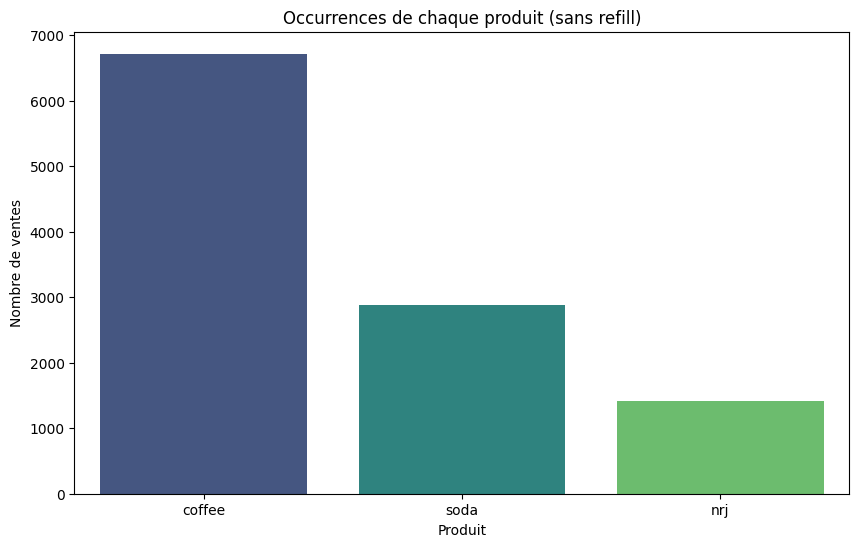

In [41]:
# Exclure 'refill' et compter les occurrences des autres produits
product_counts = df_03[df_03['product'] != 'refill']['product'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=product_counts.index, y=product_counts.values, palette='viridis')

plt.title('Occurrences de chaque produit (sans refill)')
plt.xlabel('Produit')
plt.ylabel('Nombre de ventes')
plt.show()

On peut ici constater que globalement le café est le produit phare, il se vend beaucoup plus que les autres.
Les energy drink sont les boissons les moins vendues dans la gare.

Nous allons ici introduire les différentes infomartions données dans le sujet :
    - les prix de ventes
    - les prix d'achat
    - le cout du rechargement

Nous creeons une nouvelle colonne profit qui va nous permettre de calculer le benefice de la vente ou integrer le cout du refill.
Le but sera de pouvoir analayser la rentabilité globale avec l'ajout des charges fixes données en sujet.

In [42]:

price_dict = {
        'coffee' : 1,
        'soda' : 1.6, 
        'nrj' : 1.8,
        'refill' : 0
}

df_03['selling_price'] = df_03['product'].map(price_dict)
df_03.head(2)

,full_date,day_of_week,day,month,year,hour,minute,product,machine,selling_price
0,2019-11-14 11:53:35+00:00,Thursday,14,11,2019,11,53,refill,A,0.0
1,2019-11-14 12:06:35+00:00,Thursday,14,11,2019,12,6,coffee,A,1.0


In [43]:
cost_dict = {
    'coffee': 0.3,
    'soda': 0.6,
    'nrj' : 0.8,
    'refill' : 130
}

df_03['cost_price'] = df_03['product'].map(cost_dict)
df_03['profit'] = df_03['selling_price'] - df_03['cost_price']
df_03.head(2)


,full_date,day_of_week,day,month,year,hour,minute,product,machine,selling_price,cost_price,profit
0,2019-11-14 11:53:35+00:00,Thursday,14,11,2019,11,53,refill,A,0.0,130.0,-130.0
1,2019-11-14 12:06:35+00:00,Thursday,14,11,2019,12,6,coffee,A,1.0,0.3,0.7


Creation d'une fonction pour inclure la capacité des machines dans une colonne.

Les capacité max des machines sont fournies par le client. La premiere ligne est un rechargement, nous partirons donc du principe 
que les quatres machines étaient vides au debut de l'étude.

On integre un compteur pour que chaque vente de chaque produit soit déduis de la machine correspondante (donc reellement 4 compteurs)
Nous creeons des variables pour stocker l'inventaire apres chaque vente par une machine. Ces variables s'affichent sur les lignes refill et permettent
de connaitre le stock restant pour chaque produit lors du rechargement.

Chaque rechargement est supposé complet.

In [44]:
df_04 = df_03.copy()

In [53]:
import pandas as pd

# Définir les capacités pour chaque machine
capacity_dict = {
    'A': {'coffee': 280, 'soda': 120, 'nrj': 60},
    'B': {'coffee': 280, 'soda': 120, 'nrj': 60},
    'C': {'coffee': 280, 'soda': 120, 'nrj': 60},
    'D': {'coffee': 280, 'soda': 120, 'nrj': 60}
}


# Initialiser les inventaires
initial_inventory = {machine: {product: capacity for product, capacity in capacities.items()} 
                      for machine, capacities in capacity_dict.items()}

# Fonction pour mettre à jour l'inventaire et détecter les ruptures de stock
def update_inventory_and_check_stock(df):
    # Créer une copie de l'inventaire initial pour chaque machine
    inventory = {machine: capacities.copy() for machine, capacities in initial_inventory.items()}
    
    # Liste pour stocker les résultats
    results = []
    
    for _, row in df.iterrows():
        machine = row['machine']
        product = row['product']
        
        if product == 'refill':
            # Recharger l'inventaire à la capacité maximale
            remaining = inventory[machine].copy()
            inventory[machine] = capacity_dict[machine].copy()
            results.append({
                'full_date': row['full_date'],
                'machine': machine,
                'product': product,
                'inventory': remaining,
                'stock_status': 'refill'
            })
        
        elif product in inventory[machine]:
            # Réduire l'inventaire en fonction de la vente (supposer 1 unité vendue)
            inventory[machine][product] -= 1
            
            # Vérifier si l'inventaire tombe à zéro
            if inventory[machine][product] < 0:
                inventory[machine][product] = 0
                results.append({
                    'full_date': row['full_date'],
                    'machine': machine,
                    'product': product,
                    'inventory': 1,
                    'stock_status': 'stockout'
                })
            else:
                results.append({
                    'full_date': row['full_date'],
                    'machine': machine,
                    'product': product,
                    'inventory': inventory[machine][product],
                    'stock_status': 'normal'
                })
    
    return pd.DataFrame(results)

# Appliquer la fonction pour calculer l'inventaire restant et vérifier les ruptures de stock
df_results = update_inventory_and_check_stock(df_04)

df_results.shape


(11036, 5)

In [55]:

# Filtrer les lignes où le stock est à zéro
stockout_df = df_results[df_results['stock_status'] == 'stockout']

stockout_df.head()

,full_date,machine,product,inventory,stock_status
1847,2019-11-21 13:08:02+00:00,B,soda,1,stockout
5509,2019-12-05 12:11:48+00:00,A,soda,1,stockout
7354,2019-12-12 12:20:49+00:00,A,soda,1,stockout
7380,2019-12-12 14:08:17+00:00,C,soda,1,stockout


In [77]:
# Définir les capacités pour chaque machine
capacity_dict = {
    'A': {'coffee': 280, 'soda': 120, 'nrj': 60},
    'B': {'coffee': 280, 'soda': 120, 'nrj': 60},
    'C': {'coffee': 280, 'soda': 120, 'nrj': 60},
    'D': {'coffee': 280, 'soda': 120, 'nrj': 60}

}

# Initialiser les inventaires
initial_inventory = {machine: {product: 0 for product in capacities} for machine, capacities in capacity_dict.items()}

# Fonction pour mettre à jour l'inventaire
def update_inventory(df):
    # Copie de l'inventaire pour le traitement
    inventory = {machine: capacities.copy() for machine, capacities in capacity_dict.items()}
    
    def get_remaining_inventory(row):
        machine = row['machine']
        product = row['product']
        
        if product == 'refill':
            # Afficher l'inventaire restant avant le refill
            remaining = inventory[machine].copy()
            # Recharger l'inventaire à la capacité maximale
            inventory[machine] = capacity_dict[machine].copy()
            return remaining  # Retourne l'inventaire restant avant le refill
        
        elif product in inventory[machine]:
            # Réduire l'inventaire en fonction de la vente
            if inventory[machine][product] > 0:
                inventory[machine][product] -= 1
        
        # Retourne l'inventaire restant pour le produit actuel
        return inventory[machine].get(product, 0)
    
    # Appliquer la fonction pour chaque ligne du DataFrame
    df['inventory'] = df.apply(get_remaining_inventory, axis=1)

# Appliquer la fonction pour calculer l'inventaire restant
update_inventory(df_04)

# Afficher les premiers résultats
df_04


,full_date,day_of_week,day,month,year,hour,minute,product,machine,selling_price,cost_price,profit,inventory
0,2019-11-14 11:53:35+00:00,Thursday,14,11,2019,11,53,refill,A,0.0,130.0,-130.0,"{'coffee': 280, 'soda': 120, 'nrj': 60}"
1,2019-11-14 12:06:35+00:00,Thursday,14,11,2019,12,6,coffee,A,1.0,0.3,0.7,279
2,2019-11-14 12:07:59+00:00,Thursday,14,11,2019,12,7,soda,A,1.6,0.6,1.0,119
3,2019-11-14 12:13:45+00:00,Thursday,14,11,2019,12,13,soda,A,1.6,0.6,1.0,118
4,2019-11-14 12:22:35+00:00,Thursday,14,11,2019,12,22,coffee,A,1.0,0.3,0.7,278
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11037,2019-12-25 20:10:53+00:00,Wednesday,25,12,2019,20,10,nrj,A,1.8,0.8,1.0,3
11038,2019-12-25 20:16:30+00:00,Wednesday,25,12,2019,20,16,nrj,B,1.8,0.8,1.0,2
11039,2019-12-25 20:26:35+00:00,Wednesday,25,12,2019,20,26,nrj,B,1.8,0.8,1.0,1
11040,2019-12-25 21:11:55+00:00,Wednesday,25,12,2019,21,11,nrj,B,1.8,0.8,1.0,0


In [80]:
df_04.iloc[1840:1851]

,full_date,day_of_week,day,month,year,hour,minute,product,machine,selling_price,cost_price,profit,inventory
1842,2019-11-21 12:19:51+00:00,Thursday,21,11,2019,12,19,coffee,A,1.0,0.3,0.7,278
1843,2019-11-21 12:29:09+00:00,Thursday,21,11,2019,12,29,soda,A,1.6,0.6,1.0,119
1844,2019-11-21 12:37:07+00:00,Thursday,21,11,2019,12,37,coffee,A,1.0,0.3,0.7,277
1845,2019-11-21 12:39:59+00:00,Thursday,21,11,2019,12,39,coffee,A,1.0,0.3,0.7,276
1846,2019-11-21 12:44:07+00:00,Thursday,21,11,2019,12,44,soda,A,1.6,0.6,1.0,118
1847,2019-11-21 13:01:01+00:00,Thursday,21,11,2019,13,1,coffee,A,1.0,0.3,0.7,275
1848,2019-11-21 13:07:26+00:00,Thursday,21,11,2019,13,7,soda,A,1.6,0.6,1.0,117
1849,2019-11-21 13:08:02+00:00,Thursday,21,11,2019,13,8,soda,B,1.6,0.6,1.0,0
1850,2019-11-21 13:23:35+00:00,Thursday,21,11,2019,13,23,coffee,A,1.0,0.3,0.7,274
1851,2019-11-21 13:33:01+00:00,Thursday,21,11,2019,13,33,refill,B,0.0,130.0,-130.0,"{'coffee': 0, 'soda': 0, 'nrj': 1}"


In [57]:
refill_lines = df_03[df_03['product'] == 'refill']
refill_lines.head(24)

,full_date,day_of_week,day,month,year,hour,minute,product,machine,selling_price,cost_price,profit,inventory
0,2019-11-14 11:53:35+00:00,Thursday,14,11,2019,11,53,refill,A,0.0,130.0,-130.0,"{'coffee': 280, 'soda': 120, 'nrj': 60}"
6,2019-11-14 12:47:09+00:00,Thursday,14,11,2019,12,47,refill,B,0.0,130.0,-130.0,"{'coffee': 280, 'soda': 120, 'nrj': 60}"
24,2019-11-14 13:51:23+00:00,Thursday,14,11,2019,13,51,refill,C,0.0,130.0,-130.0,"{'coffee': 280, 'soda': 120, 'nrj': 60}"
43,2019-11-14 14:54:30+00:00,Thursday,14,11,2019,14,54,refill,D,0.0,130.0,-130.0,"{'coffee': 280, 'soda': 120, 'nrj': 60}"
1840,2019-11-21 11:55:39+00:00,Thursday,21,11,2019,11,55,refill,A,0.0,130.0,-130.0,"{'coffee': 0, 'soda': 0, 'nrj': 3}"
1851,2019-11-21 13:33:01+00:00,Thursday,21,11,2019,13,33,refill,B,0.0,130.0,-130.0,"{'coffee': 0, 'soda': 0, 'nrj': 1}"
1862,2019-11-21 14:01:57+00:00,Thursday,21,11,2019,14,1,refill,C,0.0,130.0,-130.0,"{'coffee': 0, 'soda': 0, 'nrj': 0}"
1883,2019-11-21 15:00:58+00:00,Thursday,21,11,2019,15,0,refill,D,0.0,130.0,-130.0,"{'coffee': 1, 'soda': 1, 'nrj': 0}"
3678,2019-11-28 11:54:41+00:00,Thursday,28,11,2019,11,54,refill,A,0.0,130.0,-130.0,"{'coffee': 2, 'soda': 0, 'nrj': 6}"
3686,2019-11-28 12:54:01+00:00,Thursday,28,11,2019,12,54,refill,B,0.0,130.0,-130.0,"{'coffee': 0, 'soda': 1, 'nrj': 0}"


In [58]:
refill_lines.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24 entries, 0 to 9253
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   full_date      24 non-null     datetime64[ns, UTC]
 1   day_of_week    24 non-null     object             
 2   day            24 non-null     int32              
 3   month          24 non-null     int32              
 4   year           24 non-null     int32              
 5   hour           24 non-null     int32              
 6   minute         24 non-null     int32              
 7   product        24 non-null     object             
 8   machine        24 non-null     object             
 9   selling_price  24 non-null     float64            
 10  cost_price     24 non-null     float64            
 11  profit         24 non-null     float64            
 12  inventory      24 non-null     object             
dtypes: datetime64[ns, UTC](1), float64(3), int32(5), object

In [59]:
refill_lines['machine'].value_counts()

machine
A    6
B    6
C    6
D    6
Name: count, dtype: int64

On retire les 4 premieres lignes qui sont le rechargement initial des machines donc c'est pourquoi cela affiche les valeurs max.

De cette nouvelle selection, on explose la colonne inventory pour en faire un df avec des colonnes séparées, coffee, soda, nrj.
On joint ce nouveau df avec le df refill d'origine, les index sont identiques.
Cela va permettre d'indiquer dans chacune des colonnes le nombre distinct de produits restant par machine lors du refill.

On verifie que les nouvelles valeurs sont bien des entiers.
& on peut ainsi faire un groupby par machine et une somme de chaque produit restant.

In [60]:
# Enlever les 4 premières lignes
refill_lines_0 = refill_lines.iloc[4:]

# Convertir la colonne inventory en colonnes séparées pour chaque produit
inventory_df = refill_lines_0['inventory'].apply(pd.Series)

# Ajouter ces nouvelles colonnes au DataFrame original
refill_lines_0 = refill_lines_0.join(inventory_df)

# Convertir les valeurs en entiers (si nécessaire)
refill_lines_0  = refill_lines_0.astype({'coffee': 'int', 'soda': 'int', 'nrj': 'int'})

# Grouper par machine et sommer les quantités pour chaque produit
sums_per_machine = refill_lines_0.groupby('machine')[['coffee', 'soda', 'nrj']].sum()

print(sums_per_machine)

         coffee  soda  nrj
machine                   
A             2     2   12
B             1     1    8
C             0     1    0
D             1     1    1


De ces graphs, on déduit que les lundi & les vendredis sont les journées les plus intenses.
Le mercreedi est une journée 'morte' il n'y a que tres peu de vente. De meme pour le jeudi matin uniquement, les ventes redemarrent en apres midi.
N'y a t il pas de vente car pas de demande à ce moment, ou parce que les distributeur sont vide ?
Les ventes sont également moins importante le mardi que d'autre jours de la semaine, le dimanche également mais cela peut s'expliquer par la baisse de 
fréquentation des gares ce jour precis (moins de trains).

Au niveau des horaires les ventes se concentre sur une plage horaire de 5h a 17 h (correspond a des horaires de travail et donc de deplacement de personnes).
Sauf le vendredi ou l'on voit que les ventes restent importantes jusqu'en debut de soirée vers 21 .

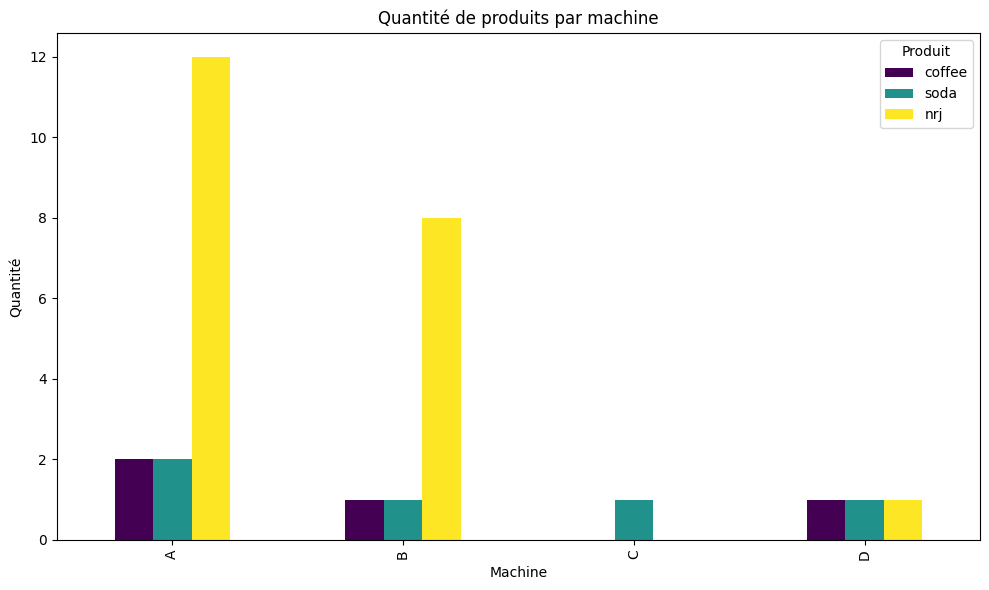

In [61]:
# Créer un graphique en barres avec matplotlib
ax = sums_per_machine.plot(kind='bar', figsize=(10, 6), colormap='viridis')

plt.xlabel('Machine')
plt.ylabel('Quantité')
plt.title('Quantité de produits par machine')
plt.legend(title='Produit')
plt.tight_layout()
plt.show()

Grace a la fonction crée précedemment on constater que les distributeurs sont effectivement quasiment toujours vides lors des rechargements.
Il ne reste que rarement des articles dans les distributeurs. Cependant si on regarde plus dans le detail, on constate que ce sont les
nrj drink qui se vendent le moins bien, les café & les sodas sont presque vide < 3 dans chaque cas.
Si on se rappelle des stocks {'coffee': 280, 'soda': 120, 'nrj': 60} on voit qu'en terme de quantité il y a un fossé entre les 3 produits, 
le café se vends plus que les sodas qui eux se vendent plus que les nrj drink.

Si on regarde les machines, on constate que la machine A est la moins performante, c'est celle avec le plus de produits restant.
Suivie de la machine B ou les energy sont les moins performante.
La machine C est elle quasiment toujours vide (1 seul soda sur 6 refill)

Création d'un nouveau DataFrame ne comprennant que les ventes, afin de pouvoir les analyser dans être géné par les rows ['product'] == 'refill'

In [62]:
df_sales = df_03[df_03['product'] != 'refill']

In [63]:
df_sales.head(2)

,full_date,day_of_week,day,month,year,hour,minute,product,machine,selling_price,cost_price,profit,inventory
1,2019-11-14 12:06:35+00:00,Thursday,14,11,2019,12,6,coffee,A,1.0,0.3,0.7,279
2,2019-11-14 12:07:59+00:00,Thursday,14,11,2019,12,7,soda,A,1.6,0.6,1.0,119


In [64]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11012 entries, 1 to 11041
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   full_date      11012 non-null  datetime64[ns, UTC]
 1   day_of_week    11012 non-null  object             
 2   day            11012 non-null  int32              
 3   month          11012 non-null  int32              
 4   year           11012 non-null  int32              
 5   hour           11012 non-null  int32              
 6   minute         11012 non-null  int32              
 7   product        11012 non-null  object             
 8   machine        11012 non-null  object             
 9   selling_price  11012 non-null  float64            
 10  cost_price     11012 non-null  float64            
 11  profit         11012 non-null  float64            
 12  inventory      11012 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(3), int32(5), ob

In [65]:
# Convertir 'inventory' en type numérique
df_sales['inventory'] = pd.to_numeric(df_sales['inventory'], errors='coerce')

df_sales.head()

C:\Users\corre\AppData\Local\Temp\ipykernel_5176\651301126.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sales['inventory'] = pd.to_numeric(df_sales['inventory'], errors='coerce')


,full_date,day_of_week,day,month,year,hour,minute,product,machine,selling_price,cost_price,profit,inventory
1,2019-11-14 12:06:35+00:00,Thursday,14,11,2019,12,6,coffee,A,1.0,0.3,0.7,279
2,2019-11-14 12:07:59+00:00,Thursday,14,11,2019,12,7,soda,A,1.6,0.6,1.0,119
3,2019-11-14 12:13:45+00:00,Thursday,14,11,2019,12,13,soda,A,1.6,0.6,1.0,118
4,2019-11-14 12:22:35+00:00,Thursday,14,11,2019,12,22,coffee,A,1.0,0.3,0.7,278
5,2019-11-14 12:37:44+00:00,Thursday,14,11,2019,12,37,soda,A,1.6,0.6,1.0,117


Analyse des Tendances Hebdomadaires : Cette heatmap permet de voir comment les ventes se répartissent au cours de la semaine pour chaque heure de la journée.

Par exemple, on peut observer si certains jours de la semaine ont plus de ventes que d'autres à des heures spécifiques.
Elle est utile pour comprendre les tendances temporelles au niveau hebdomadaire.

Chaque cellule dans la heatmap montre le nombre total de ventes pour un jour spécifique de la semaine à une heure spécifique.

ce qui est utile pour identifier les jours spécifiques de la semaine qui ont des tendances de vente particulières à différentes heures.

C:\Users\corre\AppData\Local\Temp\ipykernel_5176\2324251111.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sales['day_of_week'] = pd.Categorical(df_sales['day_of_week'], categories=day_order, ordered=True)
C:\Users\corre\AppData\Local\Temp\ipykernel_5176\2324251111.py:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_day = df_sales.pivot_table(index='day_of_week', columns='hour', aggfunc='size', fill_value=0)


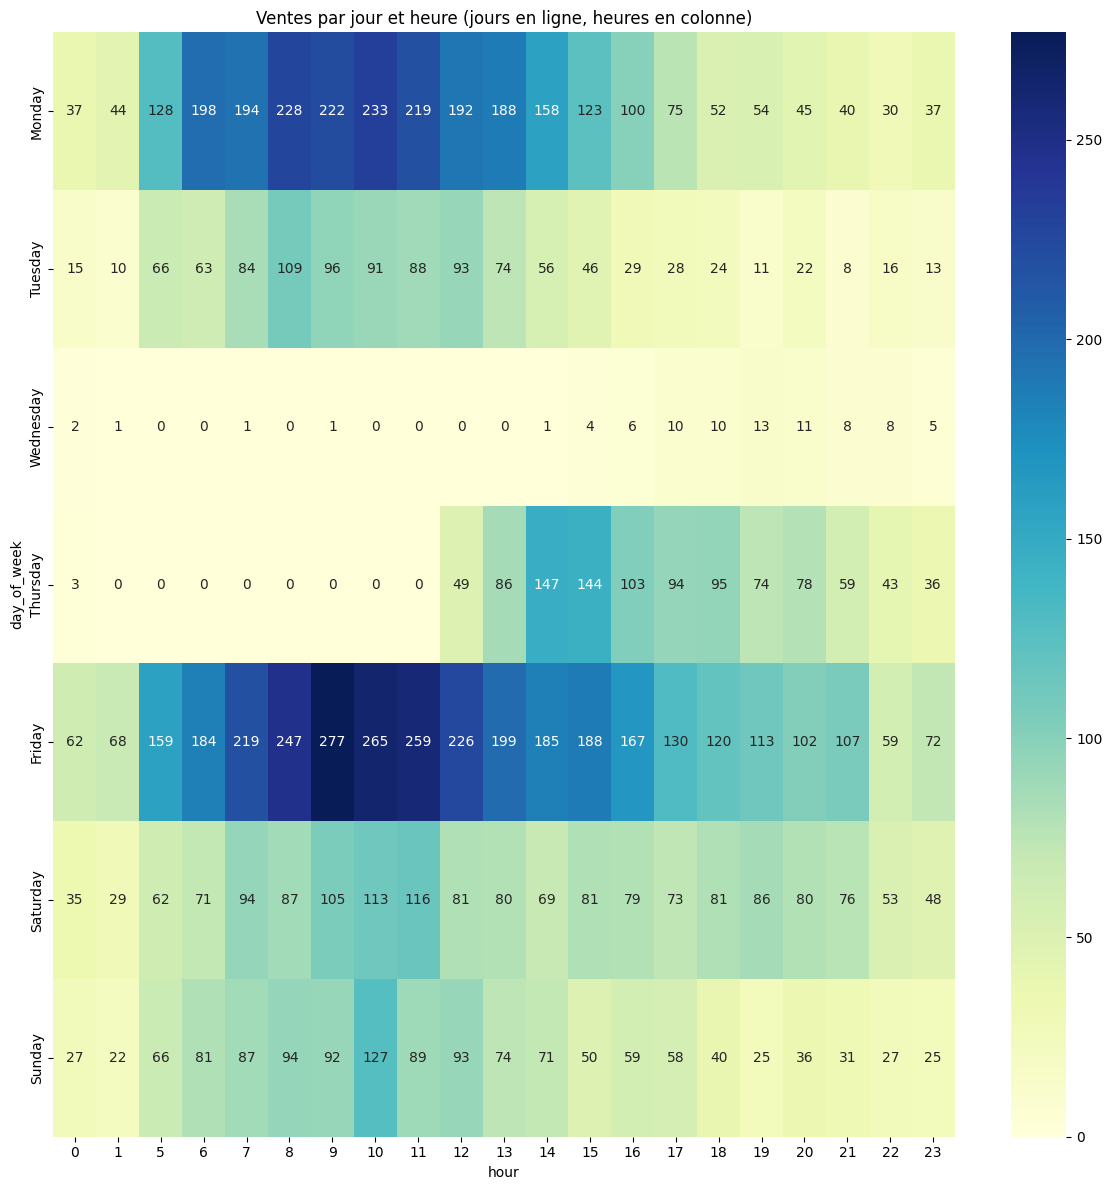

In [66]:
# Définir l'ordre des jours de la semaine
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_sales['day_of_week'] = pd.Categorical(df_sales['day_of_week'], categories=day_order, ordered=True)

# Tableau croisé dynamique pour les jours de la semaine et les heures
pivot_day = df_sales.pivot_table(index='day_of_week', columns='hour', aggfunc='size', fill_value=0)

plt.figure(figsize=(12, 12))

# Heatmap pour les jours de la semaine et les heures
sns.heatmap(pivot_day, cmap='YlGnBu', annot=True, fmt='d')
plt.title('Ventes par jour et heure (jours en ligne, heures en colonne)')

plt.tight_layout()
plt.show()

Chaque cellule dans la heatmap montre le nombre total de ventes pour une heure spécifique de la journée à un jour spécifique de la semaine.

Nous avons ici inverser les axes de la precédentes heatmap, ce sont les meme valeurs. Mais cette disposition est utile pour identifier les heures spécifiques de la journée qui sont particulièrement actives ou inactives selon les jours de la semaine. Il s'agit de faciliter la lecture

C:\Users\corre\AppData\Local\Temp\ipykernel_5176\1540835293.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_hour = df_sales.pivot_table(index='hour', columns='day_of_week', aggfunc='size', fill_value=0)


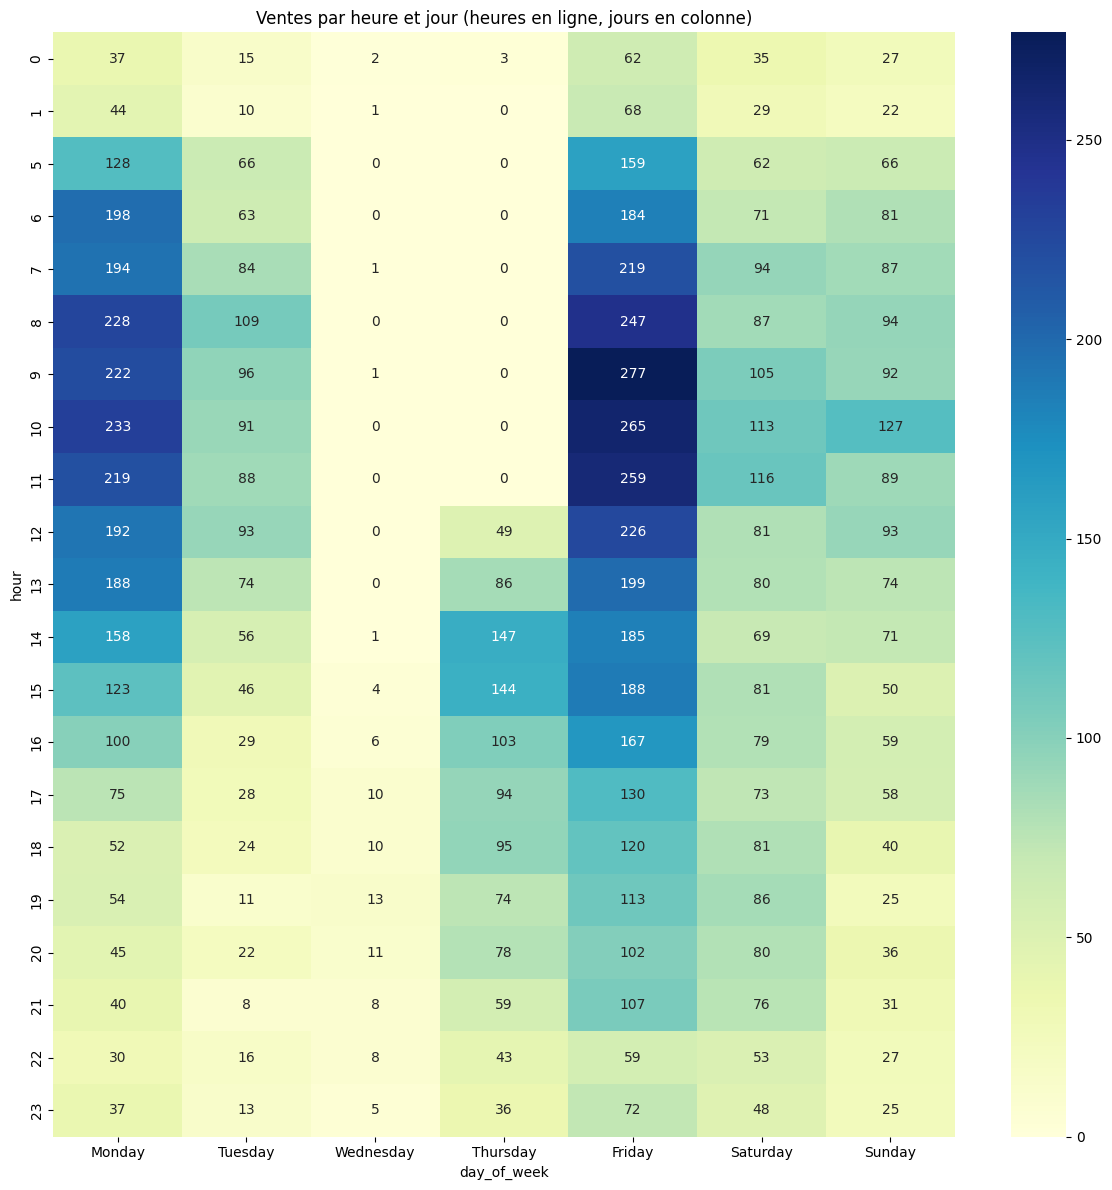

In [67]:
# Tableau croisé dynamique pour les heures et les jours de la semaine
pivot_hour = df_sales.pivot_table(index='hour', columns='day_of_week', aggfunc='size', fill_value=0)

# Afficher les heatmaps
plt.figure(figsize=(12, 12))

# Heatmap pour les heures et les jours de la semaine
sns.heatmap(pivot_hour, cmap='YlGnBu', annot=True, fmt='d')
plt.title('Ventes par heure et jour (heures en ligne, jours en colonne)')

plt.tight_layout()
plt.show()


De ces graphs, on déduit que les lundi & les vendredis sont les journées les plus intenses.
Le mercreedi est une journée 'morte' il n'y a que tres peu de vente. De meme pour le jeudi matin uniquement, les ventes redemarrent en apres midi.
N'y a t il pas de vente car pas de demande à ce moment, ou parce que les distributeur sont vide ?
Les ventes sont également moins importante le mardi que d'autre jours de la semaine, le dimanche également mais cela peut s'expliquer par la baisse de 
fréquentation des gares ce jour precis (moins de trains).

Au niveau des horaires les ventes se concentre sur une plage horaire de 5h a 17 h (correspond a des horaires de travail et donc de deplacement de personnes).
Sauf le vendredi ou l'on voit que les ventes restent importantes jusqu'en debut de soirée vers 21 .

In [68]:
# Filtrer les données pour chaque type de boisson
df_coffee = df_sales[df_sales['product'] == 'coffee']
df_soda = df_sales[df_sales['product'] == 'soda']
df_energy_drink = df_sales[df_sales['product'] == 'nrj']

C:\Users\corre\AppData\Local\Temp\ipykernel_5176\1479298321.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_day_coffee = df_coffee.pivot_table(index='day_of_week', columns='hour', aggfunc='size', fill_value=0)


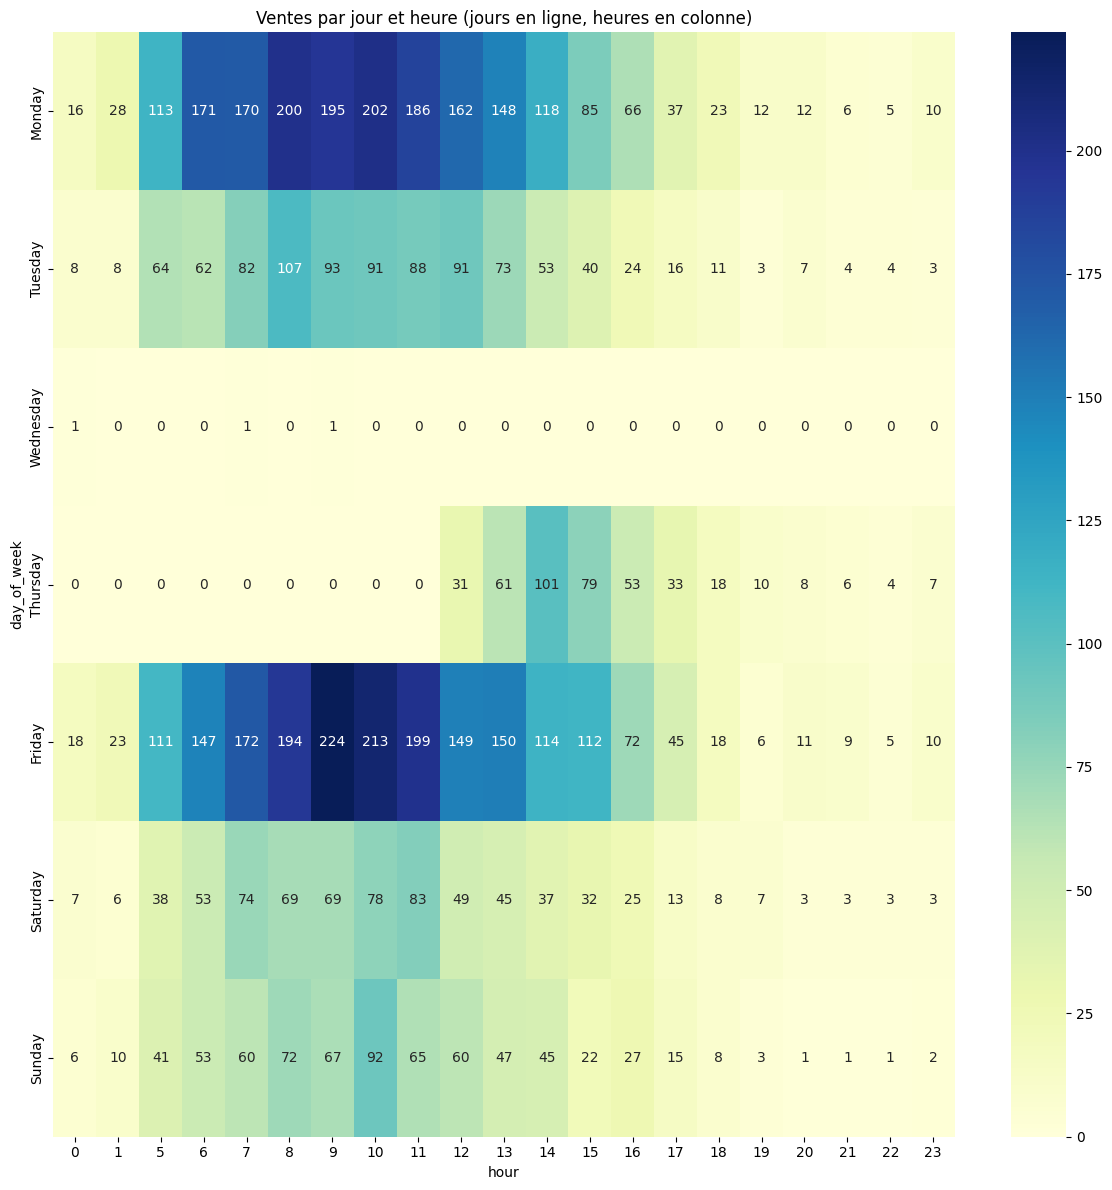

In [69]:
pivot_day_coffee = df_coffee.pivot_table(index='day_of_week', columns='hour', aggfunc='size', fill_value=0)

plt.figure(figsize=(12, 12))

# Heatmap pour les jours de la semaine et les heures
sns.heatmap(pivot_day_coffee, cmap='YlGnBu', annot=True, fmt='d')
plt.title('Ventes par jour et heure (jours en ligne, heures en colonne)')

plt.tight_layout()
plt.show()

C:\Users\corre\AppData\Local\Temp\ipykernel_5176\471591176.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_hour_coffee = df_coffee.pivot_table(index='hour', columns='day_of_week', aggfunc='size', fill_value=0)


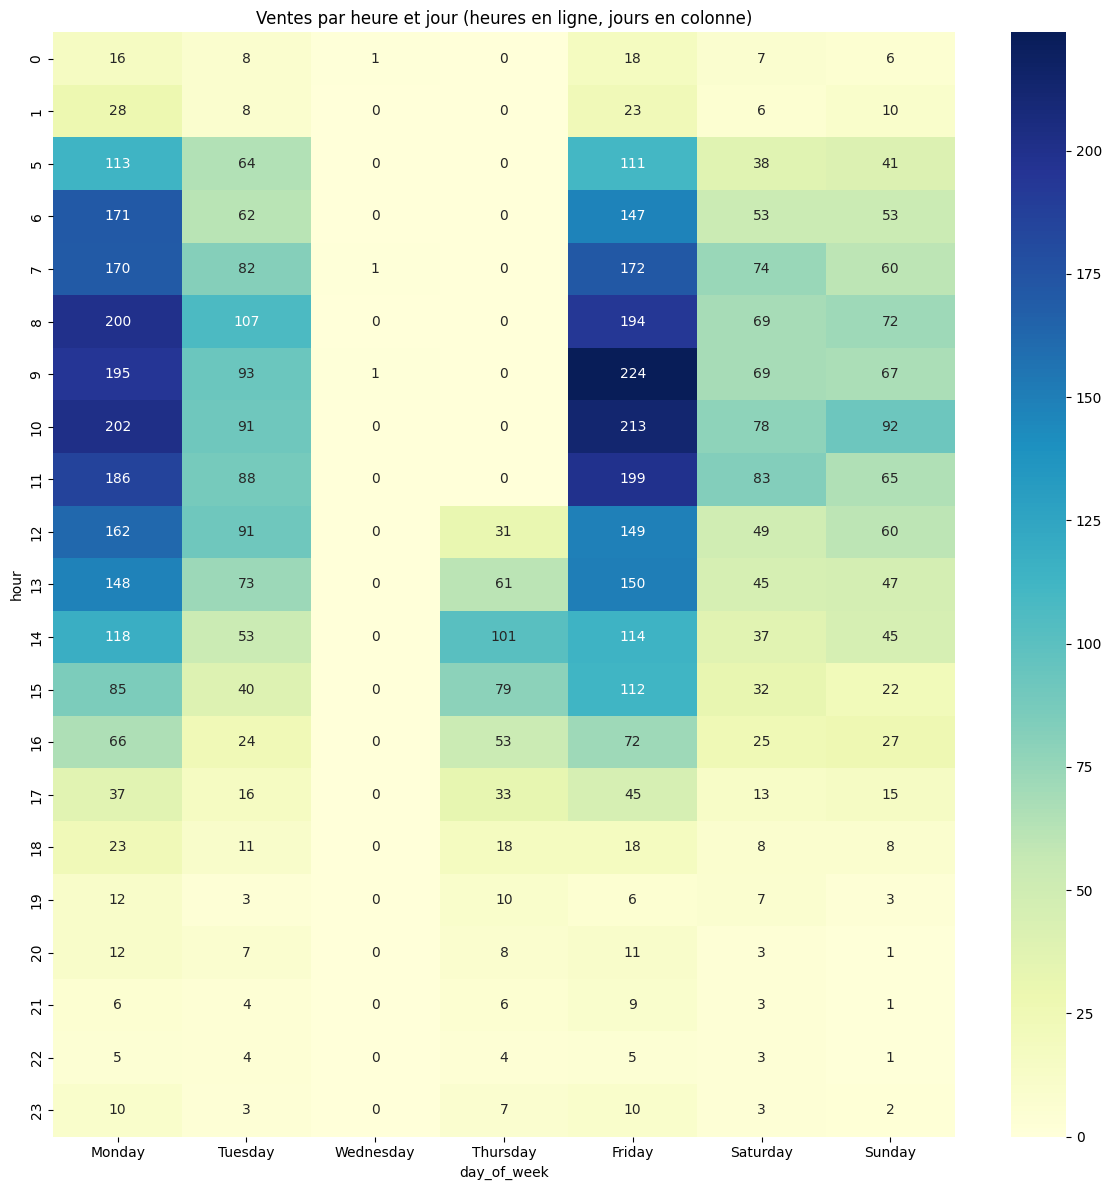

In [70]:
# Tableau croisé dynamique pour les heures et les jours de la semaine
pivot_hour_coffee = df_coffee.pivot_table(index='hour', columns='day_of_week', aggfunc='size', fill_value=0)

# Afficher les heatmaps
plt.figure(figsize=(12, 12))

# Heatmap pour les heures et les jours de la semaine
sns.heatmap(pivot_hour_coffee, cmap='YlGnBu', annot=True, fmt='d')
plt.title('Ventes par heure et jour (heures en ligne, jours en colonne)')

plt.tight_layout()
plt.show()

On constate que les ventes de café suivent globalement la tendance générales sur les jours (c'est la plus forte variable donc c'est logique).
Neanmoins on contaste que si les ventes sont toujours importantes les lundi & vendredi, le mardi presente un pic de vente également.
Au niveau des heures on constate que ce produit se vend essentiellement  en debut de journée pic de 8h a 10h et est peu demandé apres 17h

C:\Users\corre\AppData\Local\Temp\ipykernel_5176\1444170744.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_day_nrj = df_energy_drink.pivot_table(index='day_of_week', columns='hour', aggfunc='size', fill_value=0)


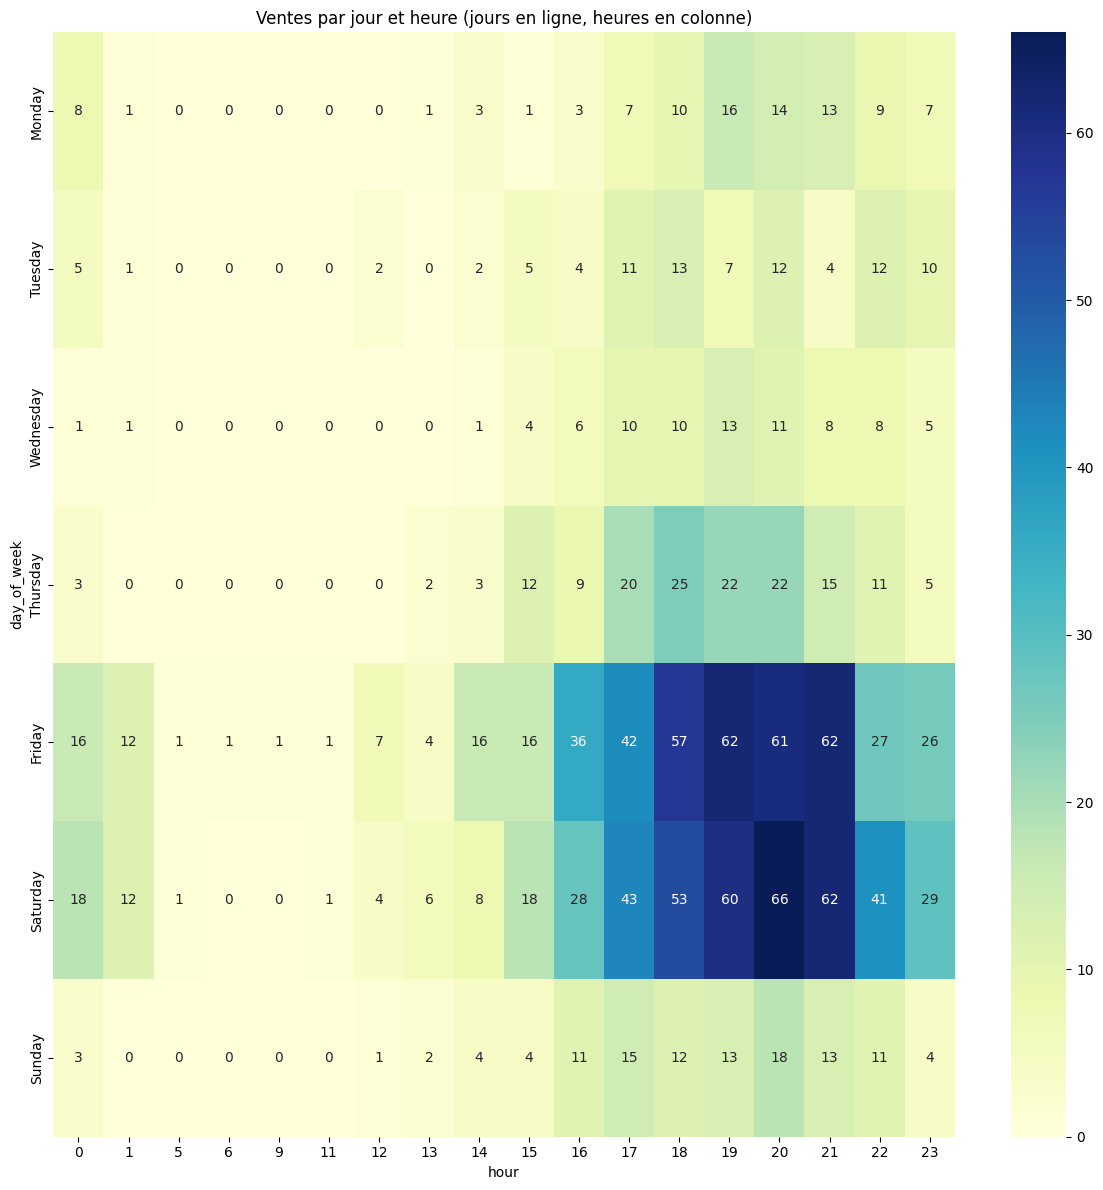

In [71]:
pivot_day_nrj = df_energy_drink.pivot_table(index='day_of_week', columns='hour', aggfunc='size', fill_value=0)

plt.figure(figsize=(12, 12))

# Heatmap pour les jours de la semaine et les heures
sns.heatmap(pivot_day_nrj, cmap='YlGnBu', annot=True, fmt='d')
plt.title('Ventes par jour et heure (jours en ligne, heures en colonne)')

plt.tight_layout()
plt.show()

C:\Users\corre\AppData\Local\Temp\ipykernel_5176\1142327996.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_hour_nrj = df_energy_drink.pivot_table(index='hour', columns='day_of_week', aggfunc='size', fill_value=0)


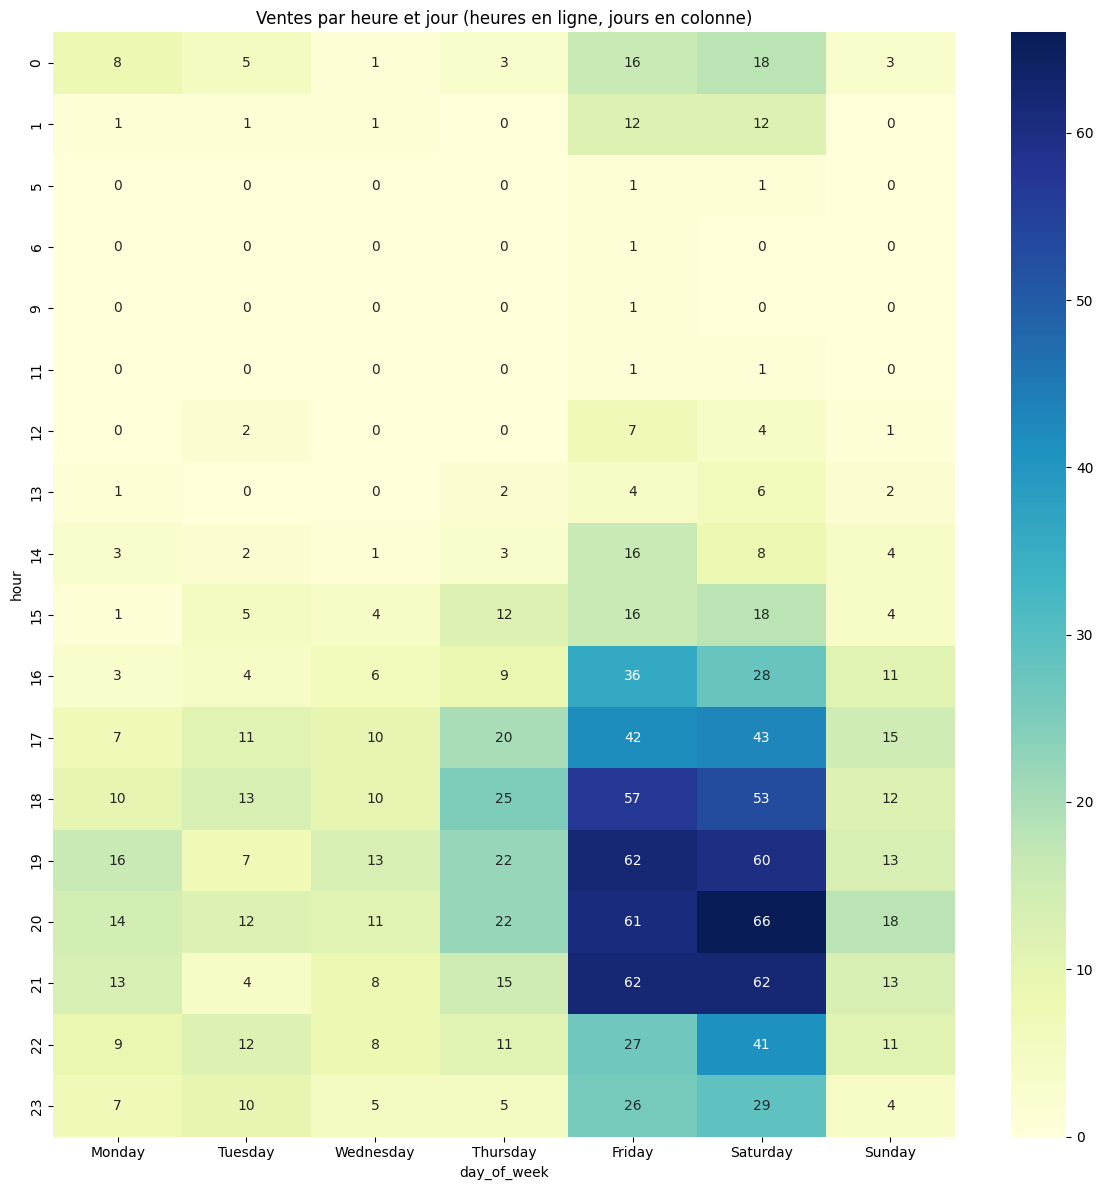

In [72]:
# Tableau croisé dynamique pour les heures et les jours de la semaine
pivot_hour_nrj = df_energy_drink.pivot_table(index='hour', columns='day_of_week', aggfunc='size', fill_value=0)

# Afficher les heatmaps
plt.figure(figsize=(12, 12))

# Heatmap pour les heures et les jours de la semaine
sns.heatmap(pivot_hour_nrj, cmap='YlGnBu', annot=True, fmt='d')
plt.title('Ventes par heure et jour (heures en ligne, jours en colonne)')

plt.tight_layout()
plt.show()

Les nrj drink elles ne repondent pas a la tendance génerales, peu demandé durant la semaine ou quasiment pas le matin notamment.
Leurs ventes sont faibles mais presente en apres midi & debut de soirée en semaine.

Elle explose ensuite le vendredi et le samedi apres mid, jusqu'a tard le soir. Elles sont le plus demandée entre 16 & 00 heures.


C:\Users\corre\AppData\Local\Temp\ipykernel_5176\473295759.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_day_soda= df_soda.pivot_table(index='day_of_week', columns='hour', aggfunc='size', fill_value=0)


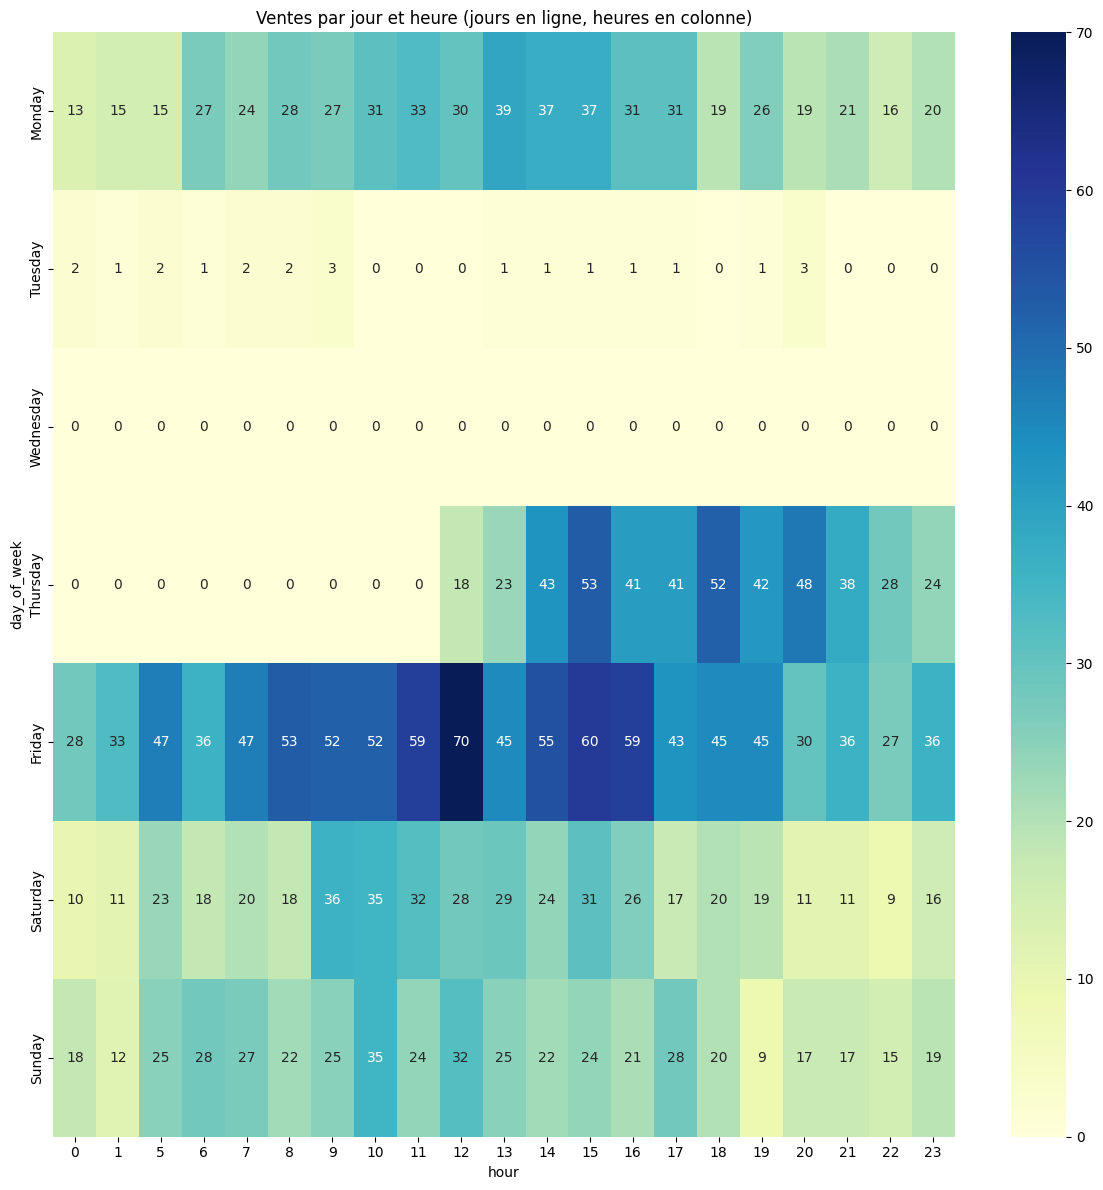

In [73]:
pivot_day_soda= df_soda.pivot_table(index='day_of_week', columns='hour', aggfunc='size', fill_value=0)

plt.figure(figsize=(12, 12))

# Heatmap pour les jours de la semaine et les heures
sns.heatmap(pivot_day_soda, cmap='YlGnBu', annot=True, fmt='d')
plt.title('Ventes par jour et heure (jours en ligne, heures en colonne)')

plt.tight_layout()
plt.show()

C:\Users\corre\AppData\Local\Temp\ipykernel_5176\1623800902.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_hour_soda = df_soda.pivot_table(index='hour', columns='day_of_week', aggfunc='size', fill_value=0)


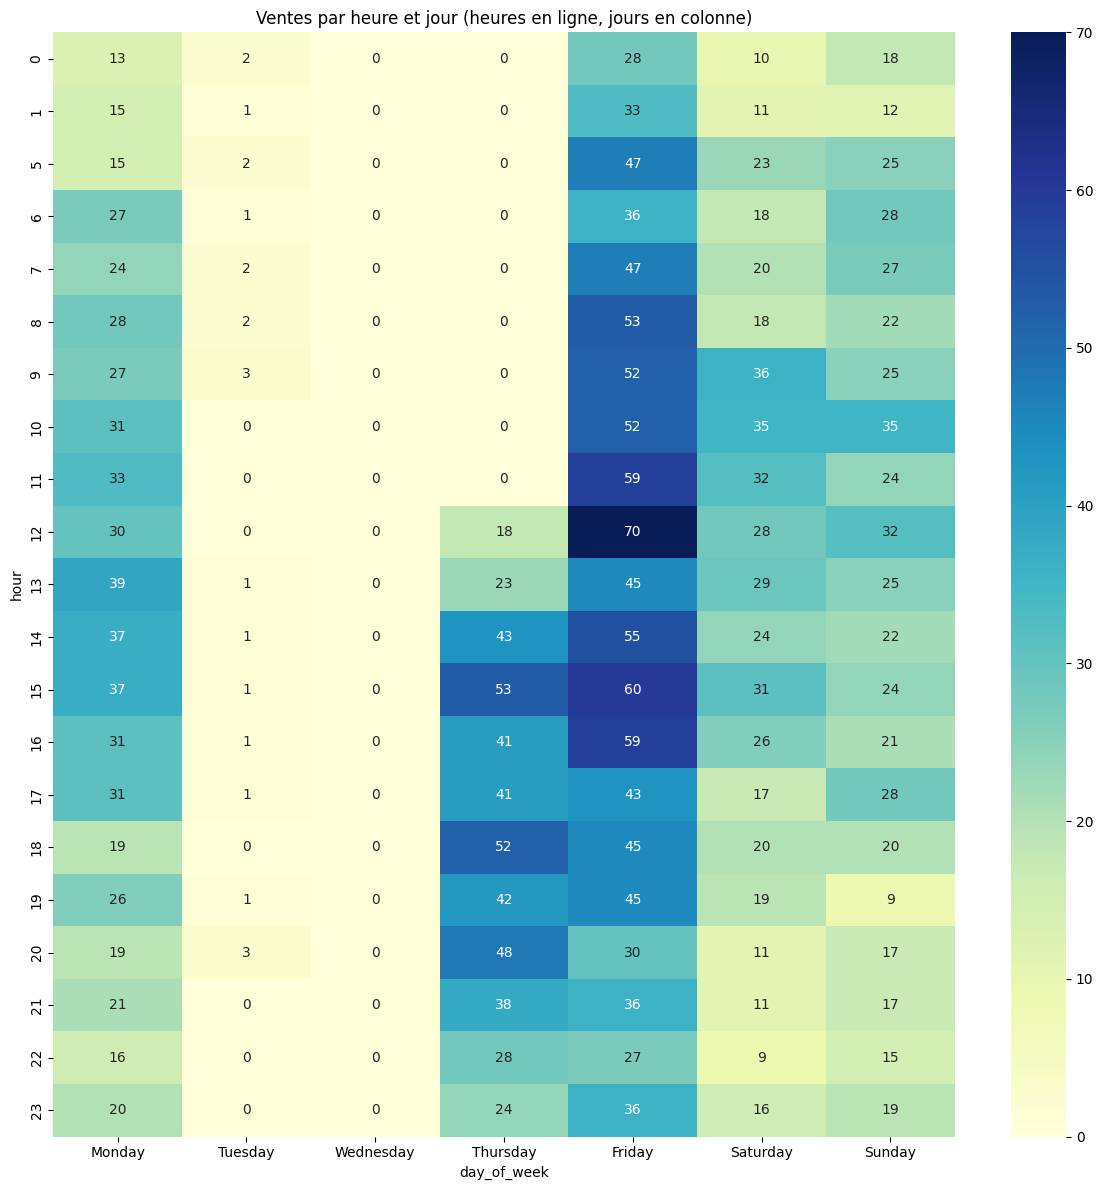

In [74]:
# Tableau croisé dynamique pour les heures et les jours de la semaine
pivot_hour_soda = df_soda.pivot_table(index='hour', columns='day_of_week', aggfunc='size', fill_value=0)

# Afficher les heatmaps
plt.figure(figsize=(12, 12))

# Heatmap pour les heures et les jours de la semaine
sns.heatmap(pivot_hour_soda, cmap='YlGnBu', annot=True, fmt='d')
plt.title('Ventes par heure et jour (heures en ligne, jours en colonne)')

plt.tight_layout()
plt.show()

Les ventes de soda sont elles plutot réguliere, meme le dimanche, avec des pic de vente le jeudi apres midi & notamment le vendredi.
On remarque une nouvelle fois que le mardi, mecredi et jeudi matin sont des journées avec tres peu de ventes.

Au niveau des ventes par tranches horaires, on constate également que celle ci sont plutot regulieres, un pic de detache cependant entre 12h et 15h.

On a donc pu a travers ces différentes analyses constater que les distributeurs sont quasiment vide lors de leur rechargement.
Ce rechargement a lieu une fois par semaine, le jeudi midi (date des refills).

A travers les pivots tables on constate que les mardi mercredi, jeudi matin realisent tres peu de vente.
La suite de l'analyse va etre de determiner a quel moment precis de la semaine les distributeurs sont vides.
On pourra ainsi determiner si les faibles ventes (ou inexistante) sont dues a un manque d'approvionnement ou simplement car pas de clients.

In [75]:
df_soda.head(1)

,full_date,day_of_week,day,month,year,hour,minute,product,machine,selling_price,cost_price,profit,inventory
2,2019-11-14 12:07:59+00:00,Thursday,14,11,2019,12,7,soda,A,1.6,0.6,1.0,119


In [85]:
# Séparation du dataset en dataset par machine pour les analyser indépendamment

df_machine_a =  df_03[df_03['machine'] == "A"]
df_machine_b =  df_03[df_03['machine'] == "B"]
df_machine_c =  df_03[df_03['machine'] == "C"]
df_machine_d =  df_03[df_03['machine'] == "D"]

In [104]:
stockout_machine_a = df_machine_a[df_machine_a['inventory'] == 0]
print('machine A shape :', stockout_machine_a.shape)
print('---'*20)
stockout_machine_b = df_machine_b[df_machine_b['inventory'] == 0]
print('machine B shape :', stockout_machine_b.shape)
print('---'*20)
stockout_machine_c = df_machine_c[df_machine_c['inventory'] == 0]
print('machine C shape:', stockout_machine_c.shape)
print('---'*20)
stockout_machine_d = df_machine_d[df_machine_d['inventory'] == 0]
print('machine D shape :', stockout_machine_d.shape)

machine A shape : (14, 13)
------------------------------------------------------------
machine B shape : (14, 13)
------------------------------------------------------------
machine C shape: (18, 13)
------------------------------------------------------------
machine D shape : (15, 13)


In [105]:
# Jour les plus fréquent ou le stock tombe en rupture

print("Machine A")
print(stockout_machine_a['day_of_week'].value_counts())
print('---'*20)
print("Machine B")
print(stockout_machine_b['day_of_week'].value_counts())
print('---'*20)
print("Machine C")
print(stockout_machine_c['day_of_week'].value_counts())
print('---'*20)
print("Machine D")
print(stockout_machine_d['day_of_week'].value_counts())

Machine A
day_of_week
Tuesday      5
Monday       4
Thursday     3
Wednesday    2
Name: count, dtype: int64
------------------------------------------------------------
Machine B
day_of_week
Tuesday      6
Thursday     3
Monday       3
Wednesday    2
Name: count, dtype: int64
------------------------------------------------------------
Machine C
day_of_week
Monday      6
Tuesday     5
Saturday    3
Sunday      3
Thursday    1
Name: count, dtype: int64
------------------------------------------------------------
Machine D
day_of_week
Tuesday      7
Monday       6
Wednesday    2
Name: count, dtype: int64


In [102]:
# Produit les plus souvent en rupture par machine

print("Machine A")
print(stockout_machine_a['product'].value_counts())
print('---'*20)
print("Machine B")
print(stockout_machine_b['product'].value_counts())
print('---'*20)
print("Machine C")
print(stockout_machine_c['product'].value_counts())
print('---'*20)
print("Machine D")
print(stockout_machine_d['product'].value_counts())

Machine A
product
soda      7
coffee    5
nrj       2
Name: count, dtype: int64
------------------------------------------------------------
Machine B
product
soda      6
coffee    5
nrj       3
Name: count, dtype: int64
------------------------------------------------------------
Machine C
product
nrj       6
soda      6
coffee    6
Name: count, dtype: int64
------------------------------------------------------------
Machine D
product
nrj       5
soda      5
coffee    5
Name: count, dtype: int64


En couplant ces tableaux avec les pivots tables réaliser plus haut, on peut maintenant conclure que s'il y a une absence de vente
sur les mardi mercredi et jeudi matin, c'est car les machines sont tres souvent en rupture d'un produit des le lundis ou le mardi
dans la plupart des cas. Les sodas sont le produits le plus souvent en rupture, suivi du café, et en derniere position les energy drink
La suite de l'analyse va etre de determiner le chiffre d'affaire moyen par jour et ainsi determiner le CA perdu.
Une fois que nous l'aurons nous pourrons en deduire le manque à gagner en termes de profit et ainsi estimer s'il est interesssant de recharger les machines.


In [112]:
df_sales

,full_date,day_of_week,day,month,year,hour,minute,product,machine,selling_price,cost_price,profit,inventory
1,2019-11-14 12:06:35+00:00,Thursday,14,11,2019,12,6,coffee,A,1.0,0.3,0.7,279
2,2019-11-14 12:07:59+00:00,Thursday,14,11,2019,12,7,soda,A,1.6,0.6,1.0,119
3,2019-11-14 12:13:45+00:00,Thursday,14,11,2019,12,13,soda,A,1.6,0.6,1.0,118
4,2019-11-14 12:22:35+00:00,Thursday,14,11,2019,12,22,coffee,A,1.0,0.3,0.7,278
5,2019-11-14 12:37:44+00:00,Thursday,14,11,2019,12,37,soda,A,1.6,0.6,1.0,117
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11037,2019-12-25 20:10:53+00:00,Wednesday,25,12,2019,20,10,nrj,A,1.8,0.8,1.0,3
11038,2019-12-25 20:16:30+00:00,Wednesday,25,12,2019,20,16,nrj,B,1.8,0.8,1.0,2
11039,2019-12-25 20:26:35+00:00,Wednesday,25,12,2019,20,26,nrj,B,1.8,0.8,1.0,1
11040,2019-12-25 21:11:55+00:00,Wednesday,25,12,2019,21,11,nrj,B,1.8,0.8,1.0,0


In [114]:
df_sales_01 = df_sales.copy()

# Ajouter une colonne pour la date sans l'heure
df_sales_01['date'] = pd.to_datetime(df_sales_01['full_date']).dt.date

# Calculer le chiffre d'affaire quotidien par date
df_sales_01 = df_sales_01.groupby('date')['selling_price'].sum().reset_index()

df_sales_01.head(2)

,date,selling_price
0,2019-11-14,212.6
1,2019-11-15,732.6


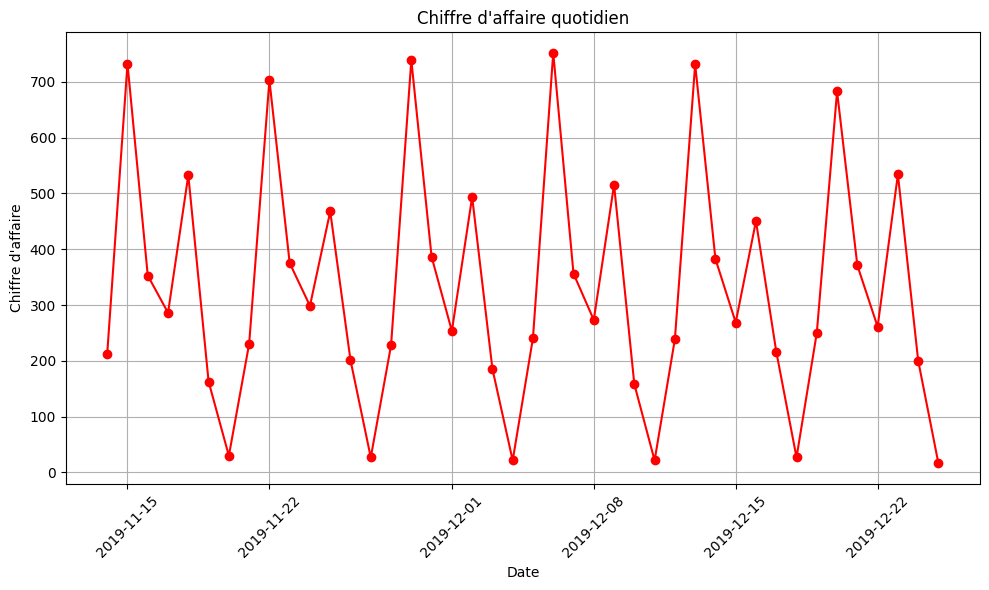

In [126]:
plt.figure(figsize=(10, 6))
plt.plot(df_sales_01['date'], df_sales_01['selling_price'], marker='o', linestyle='-', color='red')
plt.title('Chiffre d\'affaire quotidien')
plt.xlabel('Date')
plt.ylabel('Chiffre d\'affaire')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [115]:
# Ajouter une colonne pour le jour de la semaine correspondant à chaque date
df_sales_01['day_of_week'] = pd.to_datetime(df_sales_01['date']).dt.day_name()

# Calculer la moyenne du chiffre d'affaire par type de jour
average_revenue_per_day = df_sales_01.groupby('day_of_week')['selling_price'].mean()

average_revenue_per_day

day_of_week
Friday       723.533333
Monday       499.133333
Saturday     370.900000
Sunday       273.633333
Thursday     233.466667
Tuesday      187.600000
Wednesday     23.900000
Name: selling_price, dtype: float64

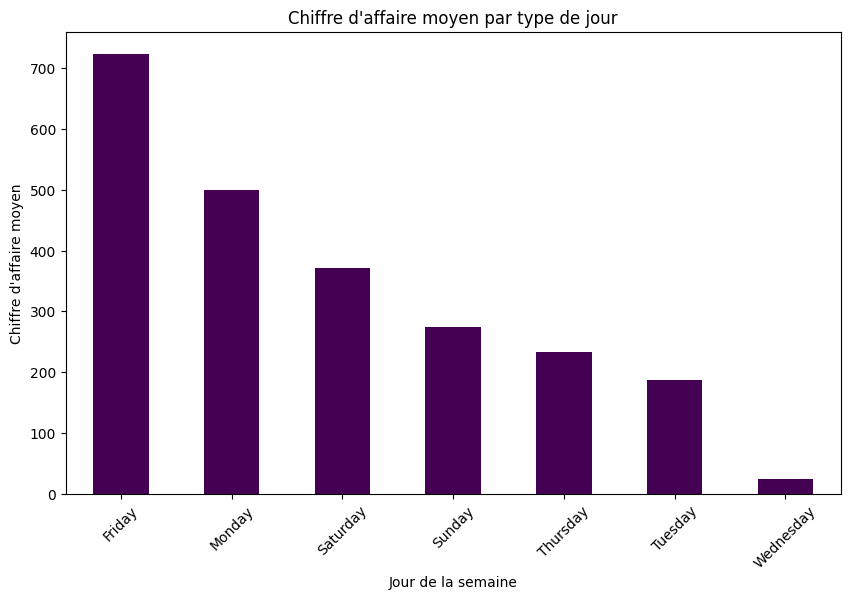

In [119]:
plt.figure(figsize=(10, 6))
average_revenue_per_day.sort_index().plot(kind='bar', colormap='viridis')
plt.title('Chiffre d\'affaire moyen par type de jour')
plt.xlabel('Jour de la semaine')
plt.ylabel('Chiffre d\'affaire moyen')
plt.xticks(rotation=45)
plt.show()

On contstate que le vendredi est le jour avec le plus gros CA, les distributeurs sont pleins et il y a beaucoup de passage le wk.
On reinsiste sur le mercredi ou aucun chiffre n'est realisé quasiment, le mardi et le jeudi sont faibles alors que le jeudi ne sont remplis
qu'a partir de midi les distributeur. 
Calculons maintenant le profit moyen par jour, en ne tenant compte que des jours ou les distributeurs sont relativement plein, on exclus donc mardi & mercredi.


In [162]:
df_sales_02 = df_sales.copy()

# Ajouter une colonne pour la date sans l'heure
df_sales_02['date'] = pd.to_datetime(df_sales_02['full_date']).dt.date

# Calculer le chiffre d'affaire quotidien par date
df_sales_02 = df_sales_02.groupby('date')['profit'].sum().reset_index()

df_sales_02.head(2)

,date,profit
0,2019-11-14,135.3
1,2019-11-15,473.1


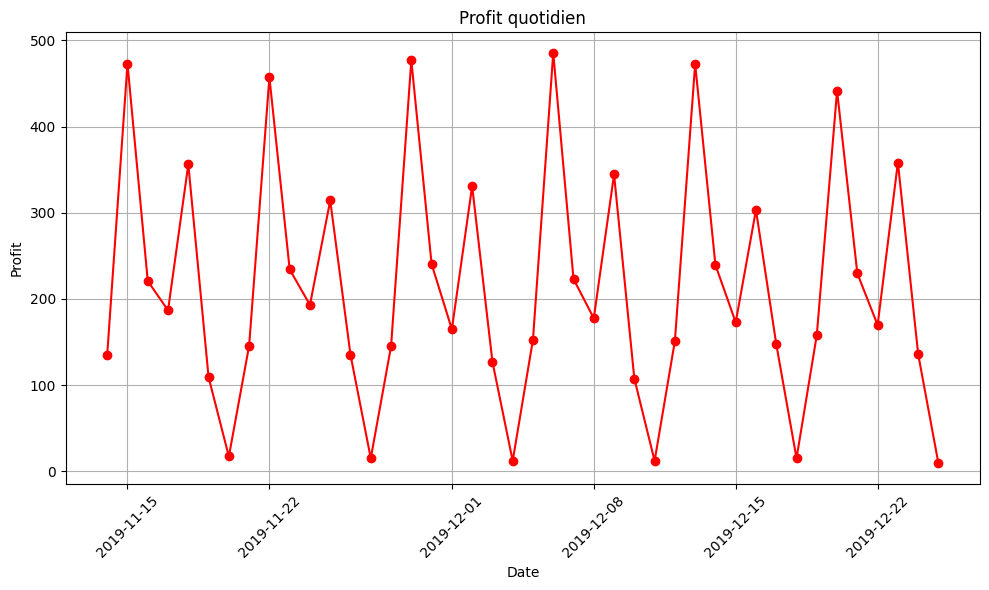

In [163]:
# Tracer le graphique
plt.figure(figsize=(10, 6))
plt.plot(df_sales_02['date'], df_sales_02['profit'], marker='o', linestyle='-', color='red')
plt.title('Profit quotidien')
plt.xlabel('Date')
plt.ylabel('Profit')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [165]:
# Ajouter une colonne pour le jour de la semaine correspondant à chaque date
df_sales_02['day_of_week'] = pd.to_datetime(df_sales_02['date']).dt.day_name()

# Calculer la moyenne du chiffre d'affaire par type de jour
profit_per_day = df_sales_02.groupby('day_of_week')['profit'].mean()

profit_per_day

day_of_week
Friday       467.900000
Monday       334.583333
Saturday     231.250000
Sunday       177.433333
Thursday     147.950000
Tuesday      127.066667
Wednesday     13.350000
Name: profit, dtype: float64

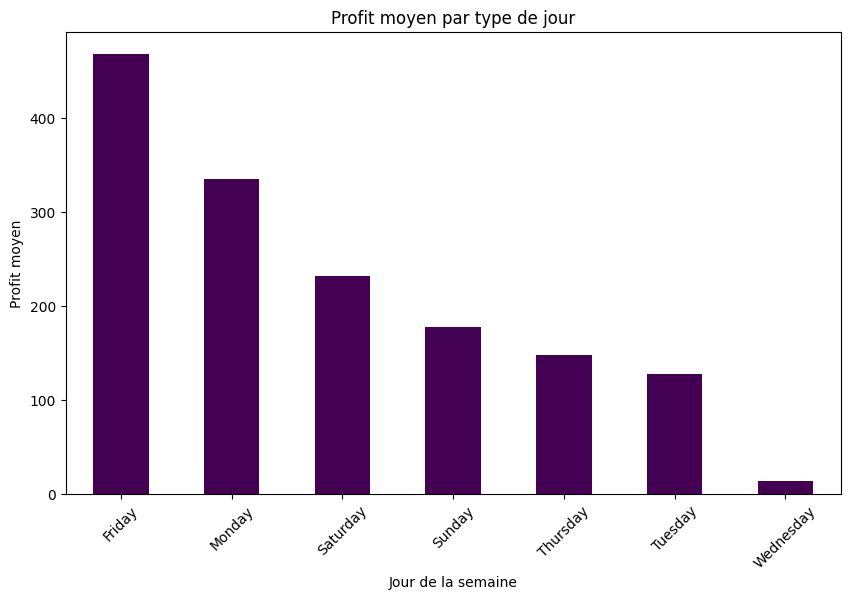

In [166]:
plt.figure(figsize=(10, 6))
profit_per_day.sort_index().plot(kind='bar', colormap='viridis')
plt.title('Profit moyen par type de jour')
plt.xlabel('Jour de la semaine')
plt.ylabel('Profit moyen')
plt.xticks(rotation=45)
plt.show()

Nous allons pouvoir conclure notre analyse & repondre a la problematique posée :

" Est il rentable d'envoyer charger une deuxieme fois par semaines les distributeurs "

Dans les infos nous savont que le refill a un cout total de 130 € pour le deplacement & toutes les machines.
Les machines sont souvent en rupture les lundi apres midi / lundi soir. Elle sont rechargées le Jeudi midi.
On a donc un manque a gagner de 2jours & demi sur la semaine ( environ 30% !).

En moyenne par jour, vendredi exclu car c'est la plus grosse journée et mardi mercredi exclus car les distributeurs sont vides, jeudi doublé car vide la moitié de la journée : 
le profit total des machines se situe entre 190 et 350€ par jour.

On n'inclut pas dans notre analyse les frais de location & d'entretien, car ils restent fixe meme si on recharge les machines une fois de plus.

Le manque a gagné se situe donc pour deux jours et demi entre 570 & 875 € par semaine ( de PROFIT pas de Chiffre d'affaire), donc si on deduit les charges de rechargement des distributeurs, on realiserais toujours un profit entre 570-130 = 440 et 875-130= 745 € par semaine.

Il est donc evident que prevoir un deuxieme rechargemment serait prolifique.

Il serait également judicieux de prevoir celui ci le lundi apres midi vers du l'heure du dejeuner (13h14h). C'est a ce moment que les distributeurs commencent a etre vide, cela permettrait d'etre complementaire avec la livraison du jeudi & permettre ainsi une bonne rotation des stocks et une rentabilité optimisée.



In [86]:
df_03.to_csv('distributeur.csv')
df_machine_a.to_csv('machine_A.csv')
df_machine_c.to_csv("machine_C.csv")
df_machine_b.to_csv('machine_B.csv')
df_machine_d.to_csv("machine_D.csv")
